In [1]:
import timeit
from datetime import datetime
import socket
import os
import glob
from tqdm import tqdm

import torch
from tensorboardX import SummaryWriter
from torch import nn, optim

from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from dataloaders.dataset import VideoDataset
from network import R3D_model, C3D_model, R2Plus1D_model, Pac3D_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import random   

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
############################
####    Parameters      ####
############################
nEpochs = 10  # Number of epochs for training
resume_epoch = 0  # Default is 0, change if want to resume
useTest = True # See evolution of the test set when training
nTestInterval = 10 # Run on test set every nTestInterval epochs
save_epoch = 10 # Store a model every save_epoch
lr = 1e-3 # Learning rate
clip_len = 256 # frames of each video

###################################
####    Options of Dataset     ####
###################################
dataset = 'CIC-IDS2018-v3-Other' 
modelName = 'Pac3D' 
saveName = modelName + '-' + dataset

if dataset == 'CIC-IDS2018':
    num_classes = 13
elif dataset == 'CIC-IDS2018-v1-DoS':
    num_classes = 4
    set_seed(35)
elif dataset == 'CIC-IDS2018-v2-DoS':
    num_classes = 4
    set_seed(50)
elif dataset == 'CIC-IDS2018-v3-DoS':
    num_classes = 4
    set_seed(6)
elif dataset == 'CIC-IDS2018-v3-DDoS':
    num_classes = 3
    set_seed(35)
elif dataset == 'CIC-IDS2018-v3-Auth':
    num_classes = 2
    set_seed(9)
elif dataset == 'CIC-IDS2018-v3-Web':
    num_classes = 3
    set_seed(2)
elif dataset == 'CIC-IDS2018-v3-Other':
    num_classes = 2
    set_seed(21)
else:
    print('No Dataset')
    raise NotImplementedError

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)

Device being used: cuda:0


In [4]:

##########################################
####   Set Model result saving dir    ####
##########################################
save_dir_root = os.path.join("/SSD/p76111262/")
resume_epoch = 0

if resume_epoch != 0:
    runs = sorted(glob.glob(os.path.join(save_dir_root, 'run', 'run_*')))
    run_id = int(runs[-1].split('_')[-1]) if runs else 0
else:
    runs = sorted(glob.glob(os.path.join(save_dir_root, 'run', 'run_*')))
    if len(runs) == 0:
        run_id = 0
    else:
        run_id = max([int(i.split('_')[-1]) for i in runs]) + 1
save_dir = os.path.join(save_dir_root, 'run', 'run_' + str(run_id))


In [5]:
######################################
####   Load model & parameters    ####
######################################
if modelName == 'C3D':
    model = C3D_model.C3D(num_classes=num_classes, pretrained=False)
    train_params = [{'params': C3D_model.get_1x_lr_params(model), 'lr': lr},
                    {'params': C3D_model.get_10x_lr_params(model), 'lr': lr * 10}]
elif modelName == 'R2Plus1D':
    model = R2Plus1D_model.R2Plus1DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = [{'params': R2Plus1D_model.get_1x_lr_params(model), 'lr': lr},
                    {'params': R2Plus1D_model.get_10x_lr_params(model), 'lr': lr * 10}]
elif modelName == 'R3D':
    model = R3D_model.R3DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = model.parameters()
elif modelName == 'Pac3D':
    model = Pac3D_model.Pac3DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = model.parameters()
else:
    print('We only implemented C3D and R2Plus1D models.')
    raise NotImplementedError


In [6]:
######################################
####   Load model & parameters    ####
######################################
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(train_params, lr=lr, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # the scheduler divides the lr by 10 every 5 epochs

if resume_epoch == 0:
    print("Training {} from scratch...".format(modelName))
else:
    checkpoint = torch.load(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar'),
                    map_location=lambda storage, loc: storage)   # Load all tensors onto the CPU
    print("Initializing weights from: {}...".format(
        os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar')))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['opt_dict'])

print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))

model.to(device)
criterion.to(device)

log_dir = os.path.join(save_dir, 'models', datetime.now().strftime('%b%d_%H-%M-%S') + '_' + socket.gethostname())
print("log dir:", log_dir)
writer = SummaryWriter(log_dir=log_dir)


Training Pac3D from scratch...
Total params: 5.66M
log dir: /SSD/p76111262/run/run_23/models/Mar31_13-45-26_uscc-ai-server


In [7]:

########################
####   Load Data    ####
########################
print('Training model on {} dataset...'.format(dataset))
train_dataloader = DataLoader(VideoDataset(dataset=dataset, split='train', clip_len=clip_len), batch_size=4, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(VideoDataset(dataset=dataset, split='val', clip_len=clip_len), batch_size=4, num_workers=0)
test_dataloader  = DataLoader(VideoDataset(dataset=dataset, split='test', clip_len=clip_len), batch_size=4, num_workers=0)

trainval_loaders = {'train': train_dataloader, 'val': val_dataloader}
trainval_sizes = {x: len(trainval_loaders[x].dataset) for x in ['train', 'val']}
test_size = len(test_dataloader.dataset)


Training model on CIC-IDS2018-v3-Other dataset...


In [8]:

train_losses = []
train_accs = []
val_losses = []
val_accs = []
y_pred = []
y_true = []

for epoch in range(resume_epoch, nEpochs):
    # each epoch has a training and validation step
    for phase in ['train', 'val']:
        start_time = timeit.default_timer()

        # reset the running loss and corrects
        running_loss = 0.0
        running_corrects = 0.0

        # set model to train() or eval() mode depending on whether it is trained
        # or being validated. Primarily affects layers such as BatchNorm or Dropout.
        if phase == 'train':
            # scheduler.step() is to be called once every epoch during trainin
            model.train()
        else:
            model.eval()

        for inputs, labels in tqdm(trainval_loaders[phase]):
            # move inputs and labels to the device the training is taking place on
            labels = labels.type(torch.LongTensor)
            inputs = Variable(inputs, requires_grad=True).to(device)
            labels = Variable(labels).to(device)
            optimizer.zero_grad()

            if phase == 'train':
                outputs = model(inputs)
            else:
                with torch.no_grad():
                    outputs = model(inputs)

            probs = nn.Softmax(dim=1)(outputs)
            preds = torch.max(probs, 1)[1]
            loss = criterion(outputs, labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()
                scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / trainval_sizes[phase]
        epoch_acc = running_corrects.double() / trainval_sizes[phase]

        if phase == 'train':
            writer.add_scalar('data/train_loss_epoch', epoch_loss, epoch)
            writer.add_scalar('data/train_acc_epoch', epoch_acc, epoch)
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
        else:
            writer.add_scalar('data/val_loss_epoch', epoch_loss, epoch)
            writer.add_scalar('data/val_acc_epoch', epoch_acc, epoch)
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc)
            
        print("[{}] Epoch: {}/{} Loss: {} Acc: {}".format(phase, epoch+1, nEpochs, epoch_loss, epoch_acc))
        stop_time = timeit.default_timer()
        print("Execution time: " + str(stop_time - start_time) + "\n")
    if epoch % save_epoch == (save_epoch - 1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'opt_dict': optimizer.state_dict(),
        }, os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar'))
        print("Save model at {}\n".format(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar')))

    if useTest and epoch % nTestInterval == (nTestInterval - 1):
        model.eval()
        start_time = timeit.default_timer()

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in tqdm(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            preds = torch.max(probs, 1)[1]
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            y_true.extend(labels.view(-1).detach().cpu().numpy())

        epoch_loss = running_loss / test_size
        epoch_acc = running_corrects.double() / test_size
    
        writer.add_scalar('data/test_loss_epoch', epoch_loss, epoch)
        writer.add_scalar('data/test_acc_epoch', epoch_acc, epoch)

        precision = precision_score(y_true, y_pred, average=None)
        recall = recall_score(y_true, y_pred, average=None)


        print("[test] Epoch: {}/{} Loss: {} Acc: {}".format(epoch+1, nEpochs, epoch_loss, epoch_acc))
        stop_time = timeit.default_timer()
        print("Execution time: " + str(stop_time - start_time) + "\n")
        
writer.close()
torch.save(model.state_dict(), "/SSD/p76111262/"+modelName+"_run"+str(run_id)+".pth")


  0%|          | 0/72 [00:00<?, ?it/s]

100%|██████████| 72/72 [00:36<00:00,  1.98it/s]


[train] Epoch: 1/10 Loss: 1.0772168977289565 Acc: 0.625
Execution time: 36.4435927758459



100%|██████████| 8/8 [00:02<00:00,  3.91it/s]


[val] Epoch: 1/10 Loss: 0.8579220464453101 Acc: 0.59375
Execution time: 2.046744503080845



100%|██████████| 72/72 [00:32<00:00,  2.18it/s]


[train] Epoch: 2/10 Loss: 0.7793711817098988 Acc: 0.6284722222222222
Execution time: 32.988309174077585



100%|██████████| 8/8 [00:01<00:00,  4.70it/s]


[val] Epoch: 2/10 Loss: 0.8039564657956362 Acc: 0.71875
Execution time: 1.7064371961168945



100%|██████████| 72/72 [00:32<00:00,  2.18it/s]


[train] Epoch: 3/10 Loss: 0.7601566199316747 Acc: 0.6319444444444444
Execution time: 32.99882707395591



100%|██████████| 8/8 [00:01<00:00,  4.79it/s]


[val] Epoch: 3/10 Loss: 0.8007482569664717 Acc: 0.71875
Execution time: 1.6740255141630769



100%|██████████| 72/72 [00:32<00:00,  2.19it/s]


[train] Epoch: 4/10 Loss: 0.7689486900344491 Acc: 0.6354166666666666
Execution time: 32.87902161502279



100%|██████████| 8/8 [00:01<00:00,  4.80it/s]


[val] Epoch: 4/10 Loss: 0.7878662785515189 Acc: 0.75
Execution time: 1.6693534930236638



100%|██████████| 72/72 [00:32<00:00,  2.19it/s]


[train] Epoch: 5/10 Loss: 0.7954495679069724 Acc: 0.6145833333333333
Execution time: 32.88219993887469



100%|██████████| 8/8 [00:01<00:00,  4.75it/s]


[val] Epoch: 5/10 Loss: 0.8885564664378762 Acc: 0.5625
Execution time: 1.687684359960258



100%|██████████| 72/72 [00:32<00:00,  2.18it/s]


[train] Epoch: 6/10 Loss: 0.8044607132259343 Acc: 0.6145833333333333
Execution time: 32.98959216219373



100%|██████████| 8/8 [00:01<00:00,  4.79it/s]


[val] Epoch: 6/10 Loss: 0.9083537058904767 Acc: 0.5625
Execution time: 1.6737318660598248



100%|██████████| 72/72 [00:32<00:00,  2.18it/s]


[train] Epoch: 7/10 Loss: 0.7798522944665618 Acc: 0.625
Execution time: 32.99628865788691



100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


[val] Epoch: 7/10 Loss: 0.850468466989696 Acc: 0.625
Execution time: 1.7116860740352422



100%|██████████| 72/72 [00:33<00:00,  2.18it/s]


[train] Epoch: 8/10 Loss: 0.798326317117446 Acc: 0.6319444444444444
Execution time: 33.02521578990854



100%|██████████| 8/8 [00:01<00:00,  4.71it/s]


[val] Epoch: 8/10 Loss: 0.8705156585201621 Acc: 0.5625
Execution time: 1.7023198050446808



100%|██████████| 72/72 [00:33<00:00,  2.18it/s]


[train] Epoch: 9/10 Loss: 0.8006686295589639 Acc: 0.625
Execution time: 33.02666086796671



100%|██████████| 8/8 [00:01<00:00,  4.73it/s]


[val] Epoch: 9/10 Loss: 0.7988560339435935 Acc: 0.71875
Execution time: 1.6932974818628281



100%|██████████| 72/72 [00:32<00:00,  2.19it/s]


[train] Epoch: 10/10 Loss: 0.7839350710726447 Acc: 0.6215277777777778
Execution time: 32.90724707604386



100%|██████████| 8/8 [00:01<00:00,  4.74it/s]


[val] Epoch: 10/10 Loss: 0.8309414982795715 Acc: 0.65625
Execution time: 1.6891549199353904

Save model at /SSD/p76111262/run/run_23/models/Pac3D-CIC-IDS2018-v3-Other_epoch-9.pth.tar



100%|██████████| 20/20 [00:05<00:00,  3.83it/s]

[test] Epoch: 10/10 Loss: 0.846894696727395 Acc: 0.5875
Execution time: 5.22868966893293



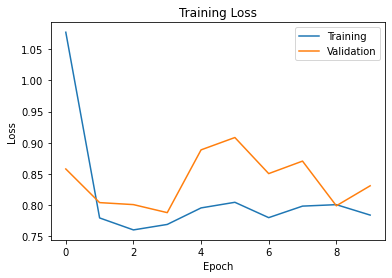

In [9]:
import matplotlib.pyplot as plt
x = list(range(nEpochs))
plt.plot(x, train_losses)
plt.plot(x, val_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

plt.savefig(save_dir + '/training_loss.png')
plt.show()

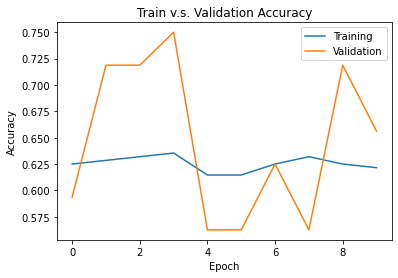

In [10]:
x = list(range(nEpochs))
np_train_accs = []
np_val_accs = []
for i in range(len(train_accs)):
    np_train_accs.append(train_accs[i].cpu().numpy())
for i in range(len(val_accs)):
    np_val_accs.append(val_accs[i].cpu().numpy())

plt.plot(x, np_train_accs)
plt.plot(x, np_val_accs)
plt.title('Train v.s. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

plt.savefig(save_dir + '/train_valid_acc.png')
plt.show()

In [11]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    y_pred = []   #保存預測label
    y_true = []   #保存實際label
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            # move inputs and labels to the device the training is taking place on
            labels = labels.type(torch.LongTensor)
            inputs = Variable(inputs, requires_grad=True).to(device)
            labels = Variable(labels).to(device)
            outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            preds = torch.max(probs, 1)[1]
            num_samples += 1
            num_correct += torch.sum(preds == labels.data)
            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            y_true.extend(labels.view(-1).detach().cpu().numpy())
        acc = num_correct.double() / test_size
        print("[test] Acc: {}".format(acc))
    return y_pred, y_true
        

In [12]:
checkpoint = torch.load(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(nEpochs - 1) + '.pth.tar'), 
                        map_location=lambda storage, loc: storage)   
print("Initializing weights from: {}...".format(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(nEpochs - 1) + '.pth.tar')))
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['opt_dict'])
y_pred, y_true = check_accuracy(test_dataloader, model)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Initializing weights from: /SSD/p76111262/run/run_23/models/Pac3D-CIC-IDS2018-v3-Other_epoch-9.pth.tar...


100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

[test] Acc: 0.5875
Precision:  0.7190923317683882
Recall:  0.5875
F1:  0.5146166574738004


['Botnet', 'Infiltration']
[0.54929577 0.88888889]


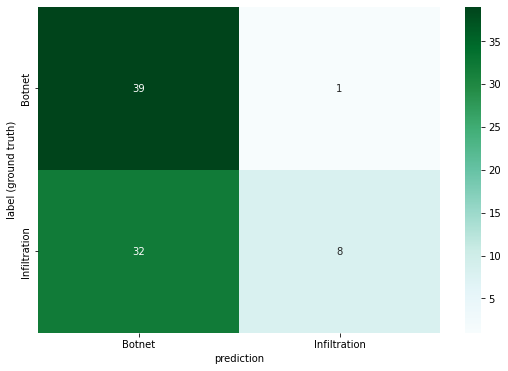

In [13]:

# 製作混淆矩陣
cf_matrix = confusion_matrix(y_true, y_pred)                               
# 計算每個class的accuracy
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)                   

class_names = []
label_txt = os.path.join('dataloaders', dataset + ".txt")  # 這裡要改成你的label.txt路徑
with open(label_txt, 'r') as f:
    for line in f:
        class_names.append(line.strip())
        
print(class_names)
print(per_cls_acc)                                            

# 開始繪製混淆矩陣並存檔
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)    
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig(save_dir + '/confusion_matrix.png')

In [14]:
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
